In [1]:
%matplotlib inline
from pprint import pprint
from collections import defaultdict

import numpy as np
import math
import matplotlib.pyplot as plt
import random
import warnings

#from sklearn.linear_model import LogisticRegression
#from sklearn.svm import SVC
#from sklearn.naive_bayes import GaussianNB
#from sklearn.linear_model import SGDClassifier
import sklearn.tree
import sklearn.ensemble

from sklearn.grid_search import GridSearchCV
from sklearn import metrics

import sys
sys.path.append('../dev')

from ml_plot import plot_validation_curve
from ml_plot import PredictCV, my_plot_learning_curve
from ml_plot import plot_prediction_curve
from ml_plot import get_dataset, eval_predictions

# Configuration

In [2]:
# PROJECT = 'nova'
# PROJECT = 'swift'
# PROJECT = 'cinder'
PROJECT = 'heat'
# PROJECT = 'glance'

# IMPORTANCE = 'crit'
# IMPORTANCE = 'high+'
IMPORTANCE = 'med+'
# IMPORTANCE = 'low+'

# SIZE = 100
#SIZE = 250
# SIZE = 0.1
SIZE = 0.5

SCORING = 'f1'         # (precision * recall) / (precision + recall)
# SCORING = 'accuracy'   # (TP + TN) / all values
# SCORING = 'precision'  # TP / (TP + FP)
# SCORING = 'recall'     # TP / (TP + FN)
# SCORING = 'average_precision'
# SCORING = 'roc_auc'

JOBS = 4

VERBOSE = 0

#warnings.simplefilter("ignore", UndefinedMetricWarning)
warnings.filterwarnings("ignore", 'F-score is ill-defined')

# Load Data

In [3]:
%%capture
Y, X = get_dataset(PROJECT, IMPORTANCE)

### Select Split Strategy

In [4]:
cv = PredictCV(len(Y), history=1000, future=500, n_iter=10)

# Extra Trees Classifier

In [5]:
estimator = sklearn.ensemble.ExtraTreesClassifier()
param_grid = {'criterion': ['gini', 'entropy'],
                  'n_estimators':[5, 7, 10, 11, 13, 15, 17, 19, 23, 25, 29],
                  'max_features':['auto', 'log2', 10, 25, 50, 75, 100, 150, 200]  }

In [6]:
grid = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=SCORING,
                    n_jobs=JOBS, pre_dispatch=2*JOBS, verbose=VERBOSE)
# grid.fit(X_train, Y_train)
grid.fit(X, Y)
print 'best_score: ', grid.best_score_
clf = grid.best_estimator_
grid.best_estimator_

best_score:  0.464198015837


ExtraTreesClassifier(bootstrap=False, compute_importances=None,
           criterion='entropy', max_depth=None, max_features=200,
           max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
           min_samples_split=2, n_estimators=23, n_jobs=1, oob_score=False,
           random_state=None, verbose=0)

### Validation Curves

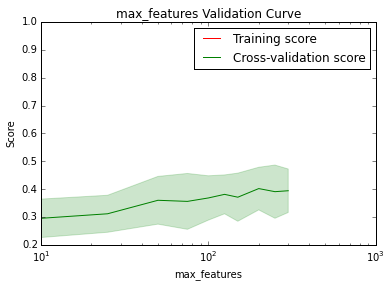

In [7]:
best_score, param_val, param_name = \
    plot_validation_curve(clf,
                          # X_train, Y_train,
                          X, Y,
                          "max_features", [10, 25, 50, 75, 100, 125, 150, 200, 250, 300],
                          "max_features Validation Curve",
                          cv=cv, scoring=SCORING, n_jobs=JOBS)

In [8]:
print 'Best score of', best_score, 'when setting', param_name, 'to',  param_val

Best score of 0.40237528844 when setting max_features to 200


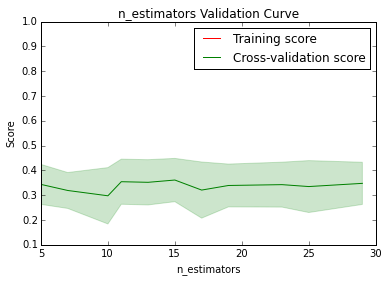

In [9]:
best_score, param_val, param_name = \
    plot_validation_curve(clf,
                          # X_train, Y_train,
                          X, Y,
                          "n_estimators", [5, 7, 10, 11, 13, 15, 17, 19, 23, 25, 29],
                          "n_estimators Validation Curve",
                          cv=cv, scoring=SCORING, n_jobs=JOBS, scale='linear')

In [10]:
print 'Best score of', best_score, 'when setting', param_name, 'to',  param_val

Best score of 0.361523031143 when setting n_estimators to 15


### Learning Curve

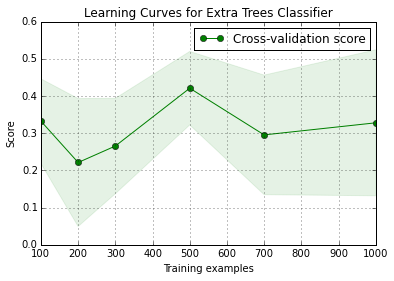

In [11]:
title = "Learning Curves for Extra Trees Classifier"
my_plot_learning_curve(clf, title, X, Y,
                           n_jobs=JOBS, future=100,
                           history_sizes=[100, 200, 300, 500, 700, 1000])
plt.show()

### Prediction Curve

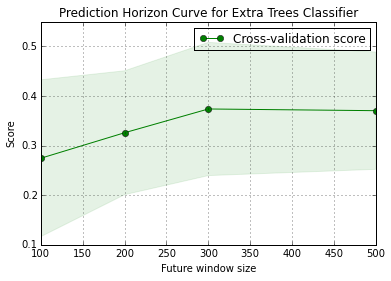

In [12]:
title = "Prediction Horizon Curve for Extra Trees Classifier"
plot_prediction_curve(clf, title, X, Y,
                           n_jobs=JOBS, history=1000,
                           future_sizes=[100, 200, 300, 500])
plt.show()

In [13]:
ET_results = eval_predictions(clf, X, Y, history_sizes=[300, 500, 700, 1000], future_sizes=[100, 200, 500])

** Predictions for hist=300 future=100 **

F1:        0.40  +/- 0.12
Accuracy:  0.68  +/- 0.04
Precision: 0.60  +/- 0.15
Recall:    0.32  +/- 0.14

Aggregate Confusion Matrix - 10 iterations
[[562  76]
 [246 116]]


** Predictions for hist=300 future=200 **

F1:        0.33  +/- 0.16
Accuracy:  0.71  +/- 0.07
Precision: 0.47  +/- 0.20
Recall:    0.26  +/- 0.13

Aggregate Confusion Matrix - 10 iterations
[[1238  158]
 [ 424  180]]


** Predictions for hist=300 future=500 **

F1:        0.33  +/- 0.10
Accuracy:  0.72  +/- 0.06
Precision: 0.43  +/- 0.09
Recall:    0.28  +/- 0.12

Aggregate Confusion Matrix - 10 iterations
[[3198  486]
 [ 920  396]]


** Predictions for hist=500 future=100 **

F1:        0.25  +/- 0.18
Accuracy:  0.77  +/- 0.06
Precision: 0.44  +/- 0.27
Recall:    0.19  +/- 0.15

Aggregate Confusion Matrix - 10 iterations
[[717  45]
 [182  56]]


** Predictions for hist=500 future=200 **

F1:        0.40  +/- 0.12
Accuracy:  0.72  +/- 0.06
Precision: 0.56  +/- 0.17
Recall:

/Users/doug/anaconda/lib/python2.7/site-packages/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [14]:
ET_clf = clf